special thanks to Dilshan Anurada


In [1]:
# install.packages("osmdata")
# install.packages("sf")
# install.packages("tmap")
# install.packages("terra")

library(osmdata)
library(sf)
library(tmap)
library(dplyr)
library(tidyr)

tmap_mode("plot")

Warning message:
"package 'osmdata' was built under R version 4.4.3"
Data (c) OpenStreetMap contributors, ODbL 1.0. https://www.openstreetmap.org/copyright

Warning message:
"package 'sf' was built under R version 4.4.3"
Linking to GEOS 3.13.0, GDAL 3.10.1, PROJ 9.5.1; sf_use_s2() is TRUE

Warning message:
"package 'tmap' was built under R version 4.4.3"
Warning message:
"package 'dplyr' was built under R version 4.4.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'tidyr' was built under R version 4.4.3"
ℹ tmap mode set to "plot".


Issuing query to Overpass API ...

Announced endpoint: none

Query complete!

converting OSM data to sf format

[v3->v4] `tm_layout()`: use `tm_title()` instead of `tm_layout(main.title = )`


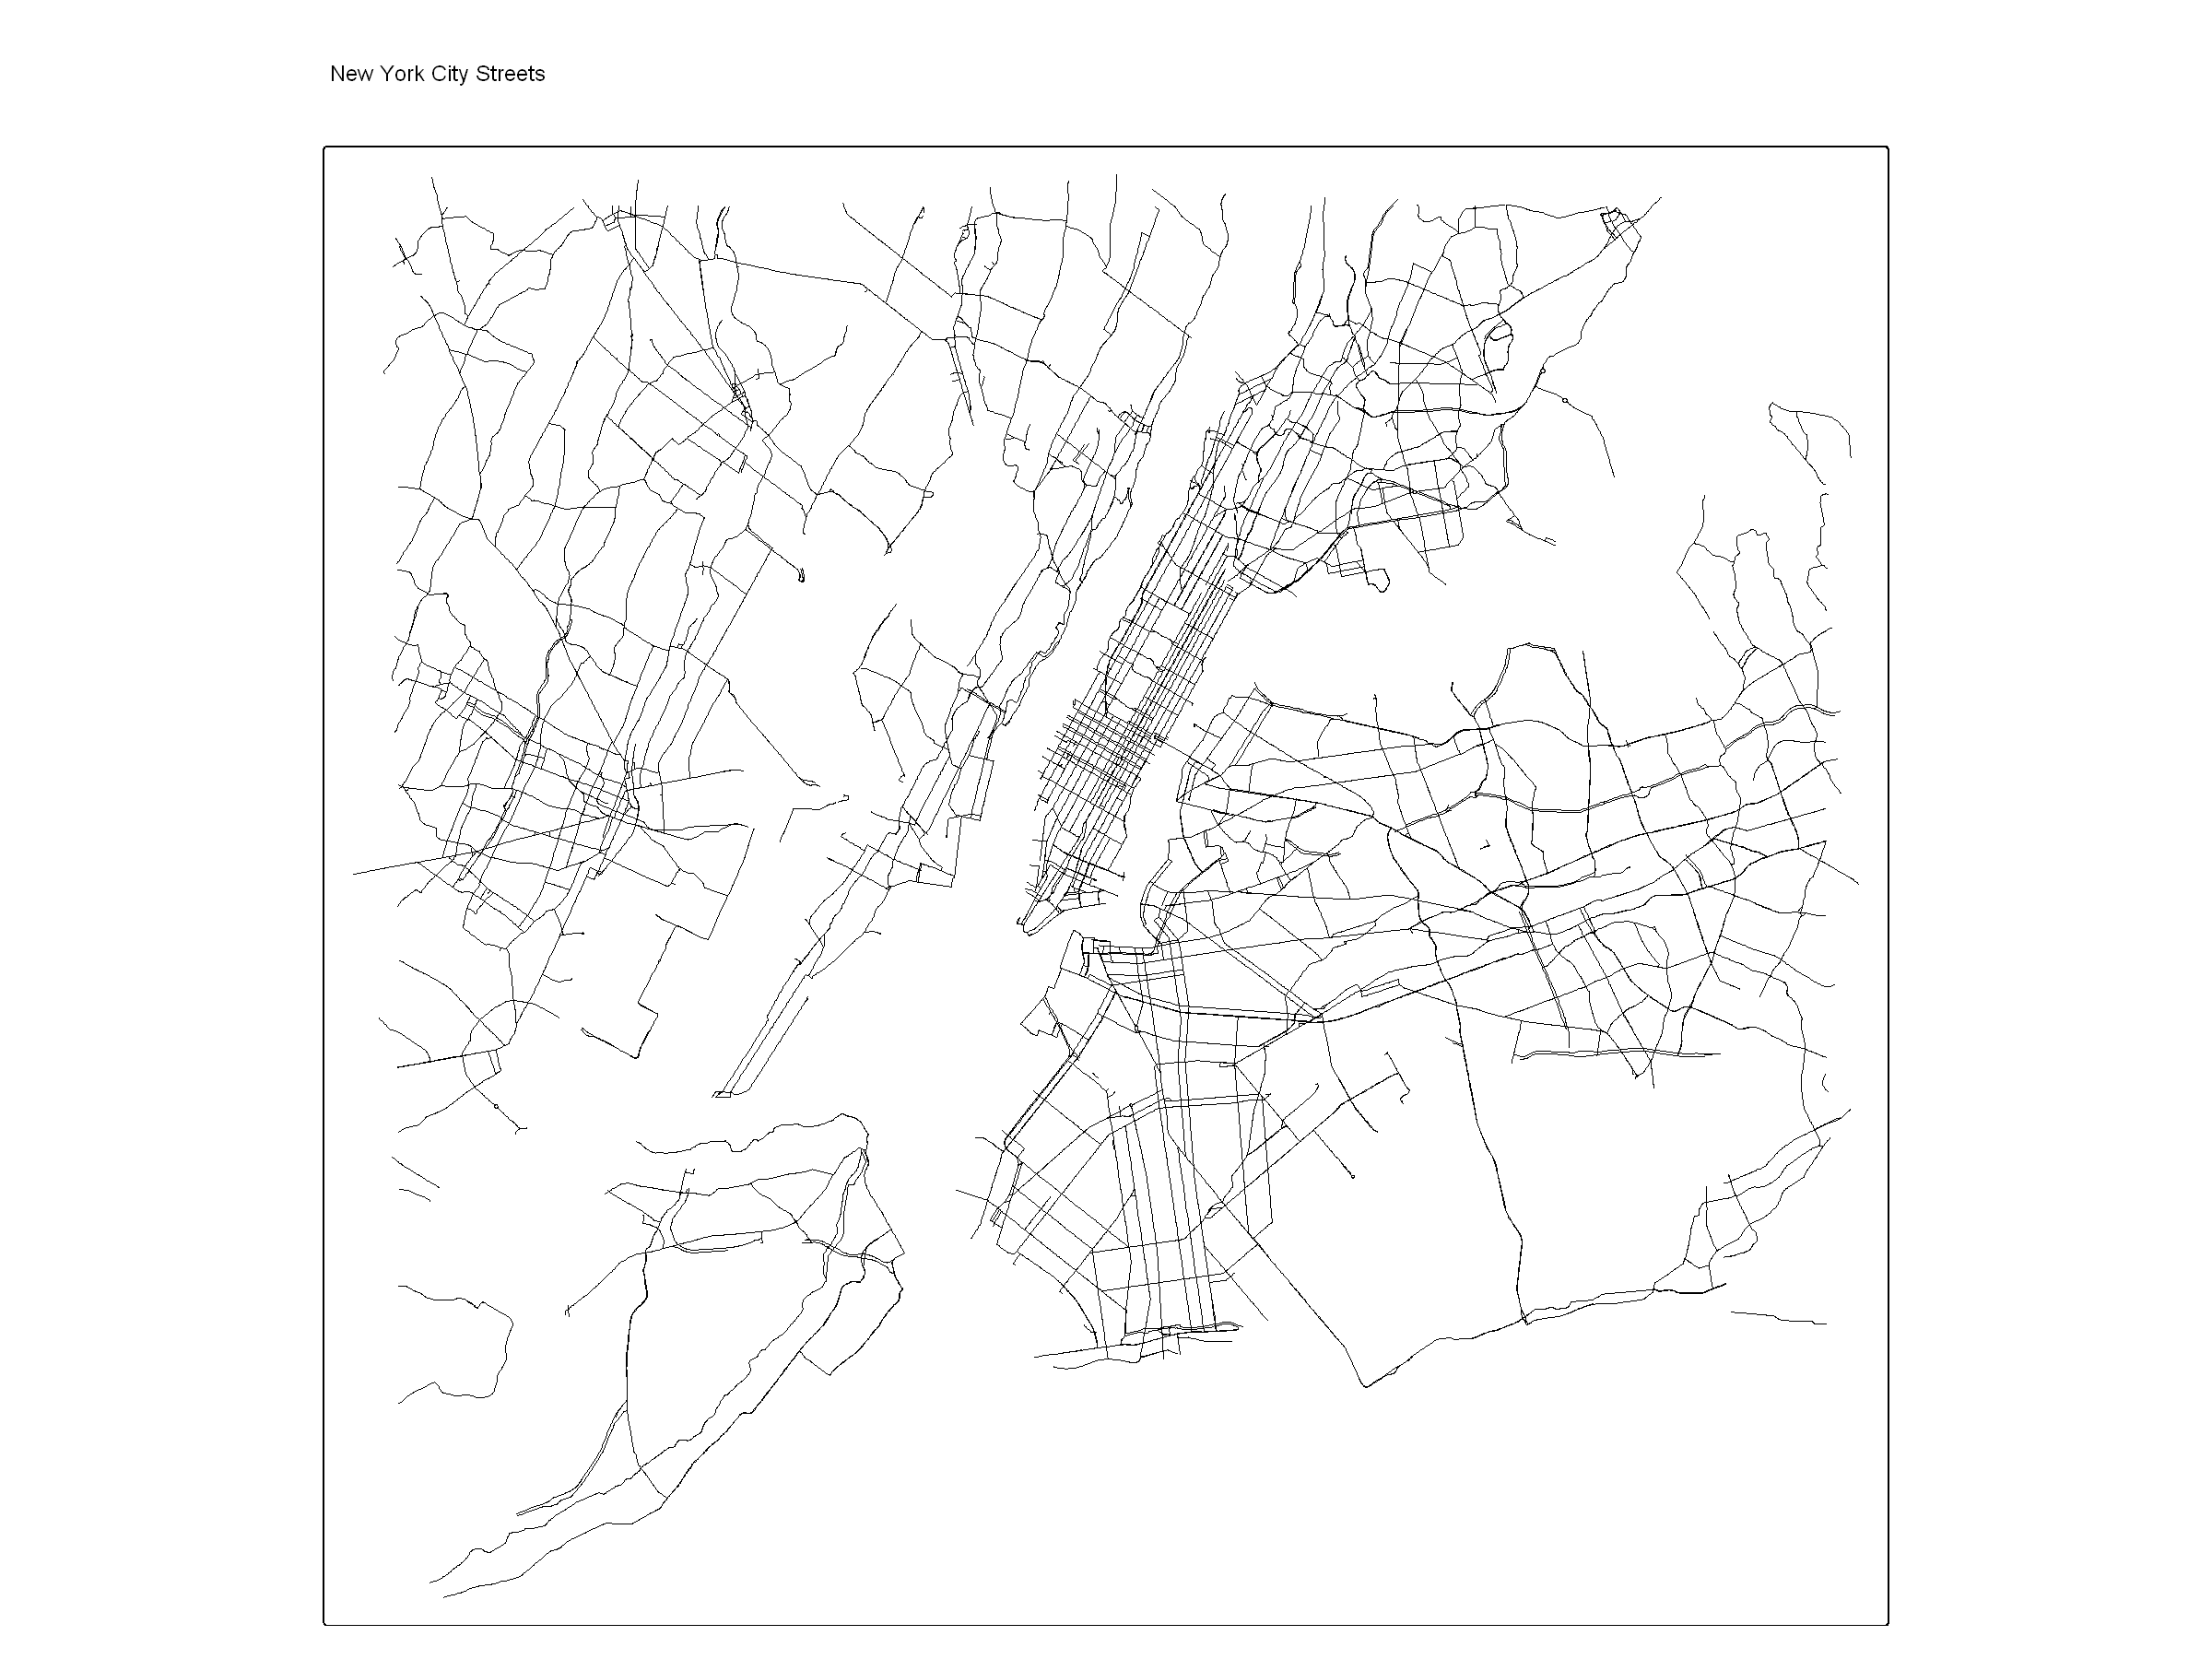

In [73]:
# nyc_bbox <- c(left = -74.2591, bottom = 40.4774, right = -73.7004, top = 40.9176)
nyc_bbox <- getbb("New York, USA")

nyc_streets <- opq(bbox = nyc_bbox) %>%
  add_osm_feature(key = "highway",     
  value = c("primary","secondary")
) %>%
  osmdata_sf(quiet = FALSE)  #

nyc_streets_lines <- nyc_streets$osm_lines

# Plot the NYC streets using tmap
tm_shape(nyc_streets_lines) +
  tm_lines(col = "black", lwd = 0.5) +
  tm_layout(main.title = "New York City Streets", 
            main.title.size = 1.2,
            bg.color = "white")

In [67]:
# Load the dataset
# file.exists("/Users/dilshananurada/NYC_Collisions.csv") #check the file existence 
accidents = read.csv("NYC_Collisions.csv") # load the dataset
nrow(accidents)

[1] 238421



── tmap v3 code detected ───────────────────────────────────────────────────────

[v3->v4] `tm_symbols()`: migrate the argument(s) related to the scale of the
visual variable `fill` namely 'palette' (rename to 'values') to fill.scale =
tm_scale(<HERE>).
[v3->v4] `symbols()`: use `fill_alpha` instead of `alpha`.
[v3->v4] `symbols()`: migrate the argument(s) related to the legend of the
visual variable `fill` namely 'title.col' (rename to 'title') to 'fill.legend =
tm_legend(<HERE>)'
[v3->v4] `tm_layout()`: use `tm_title()` instead of `tm_layout(main.title = )`


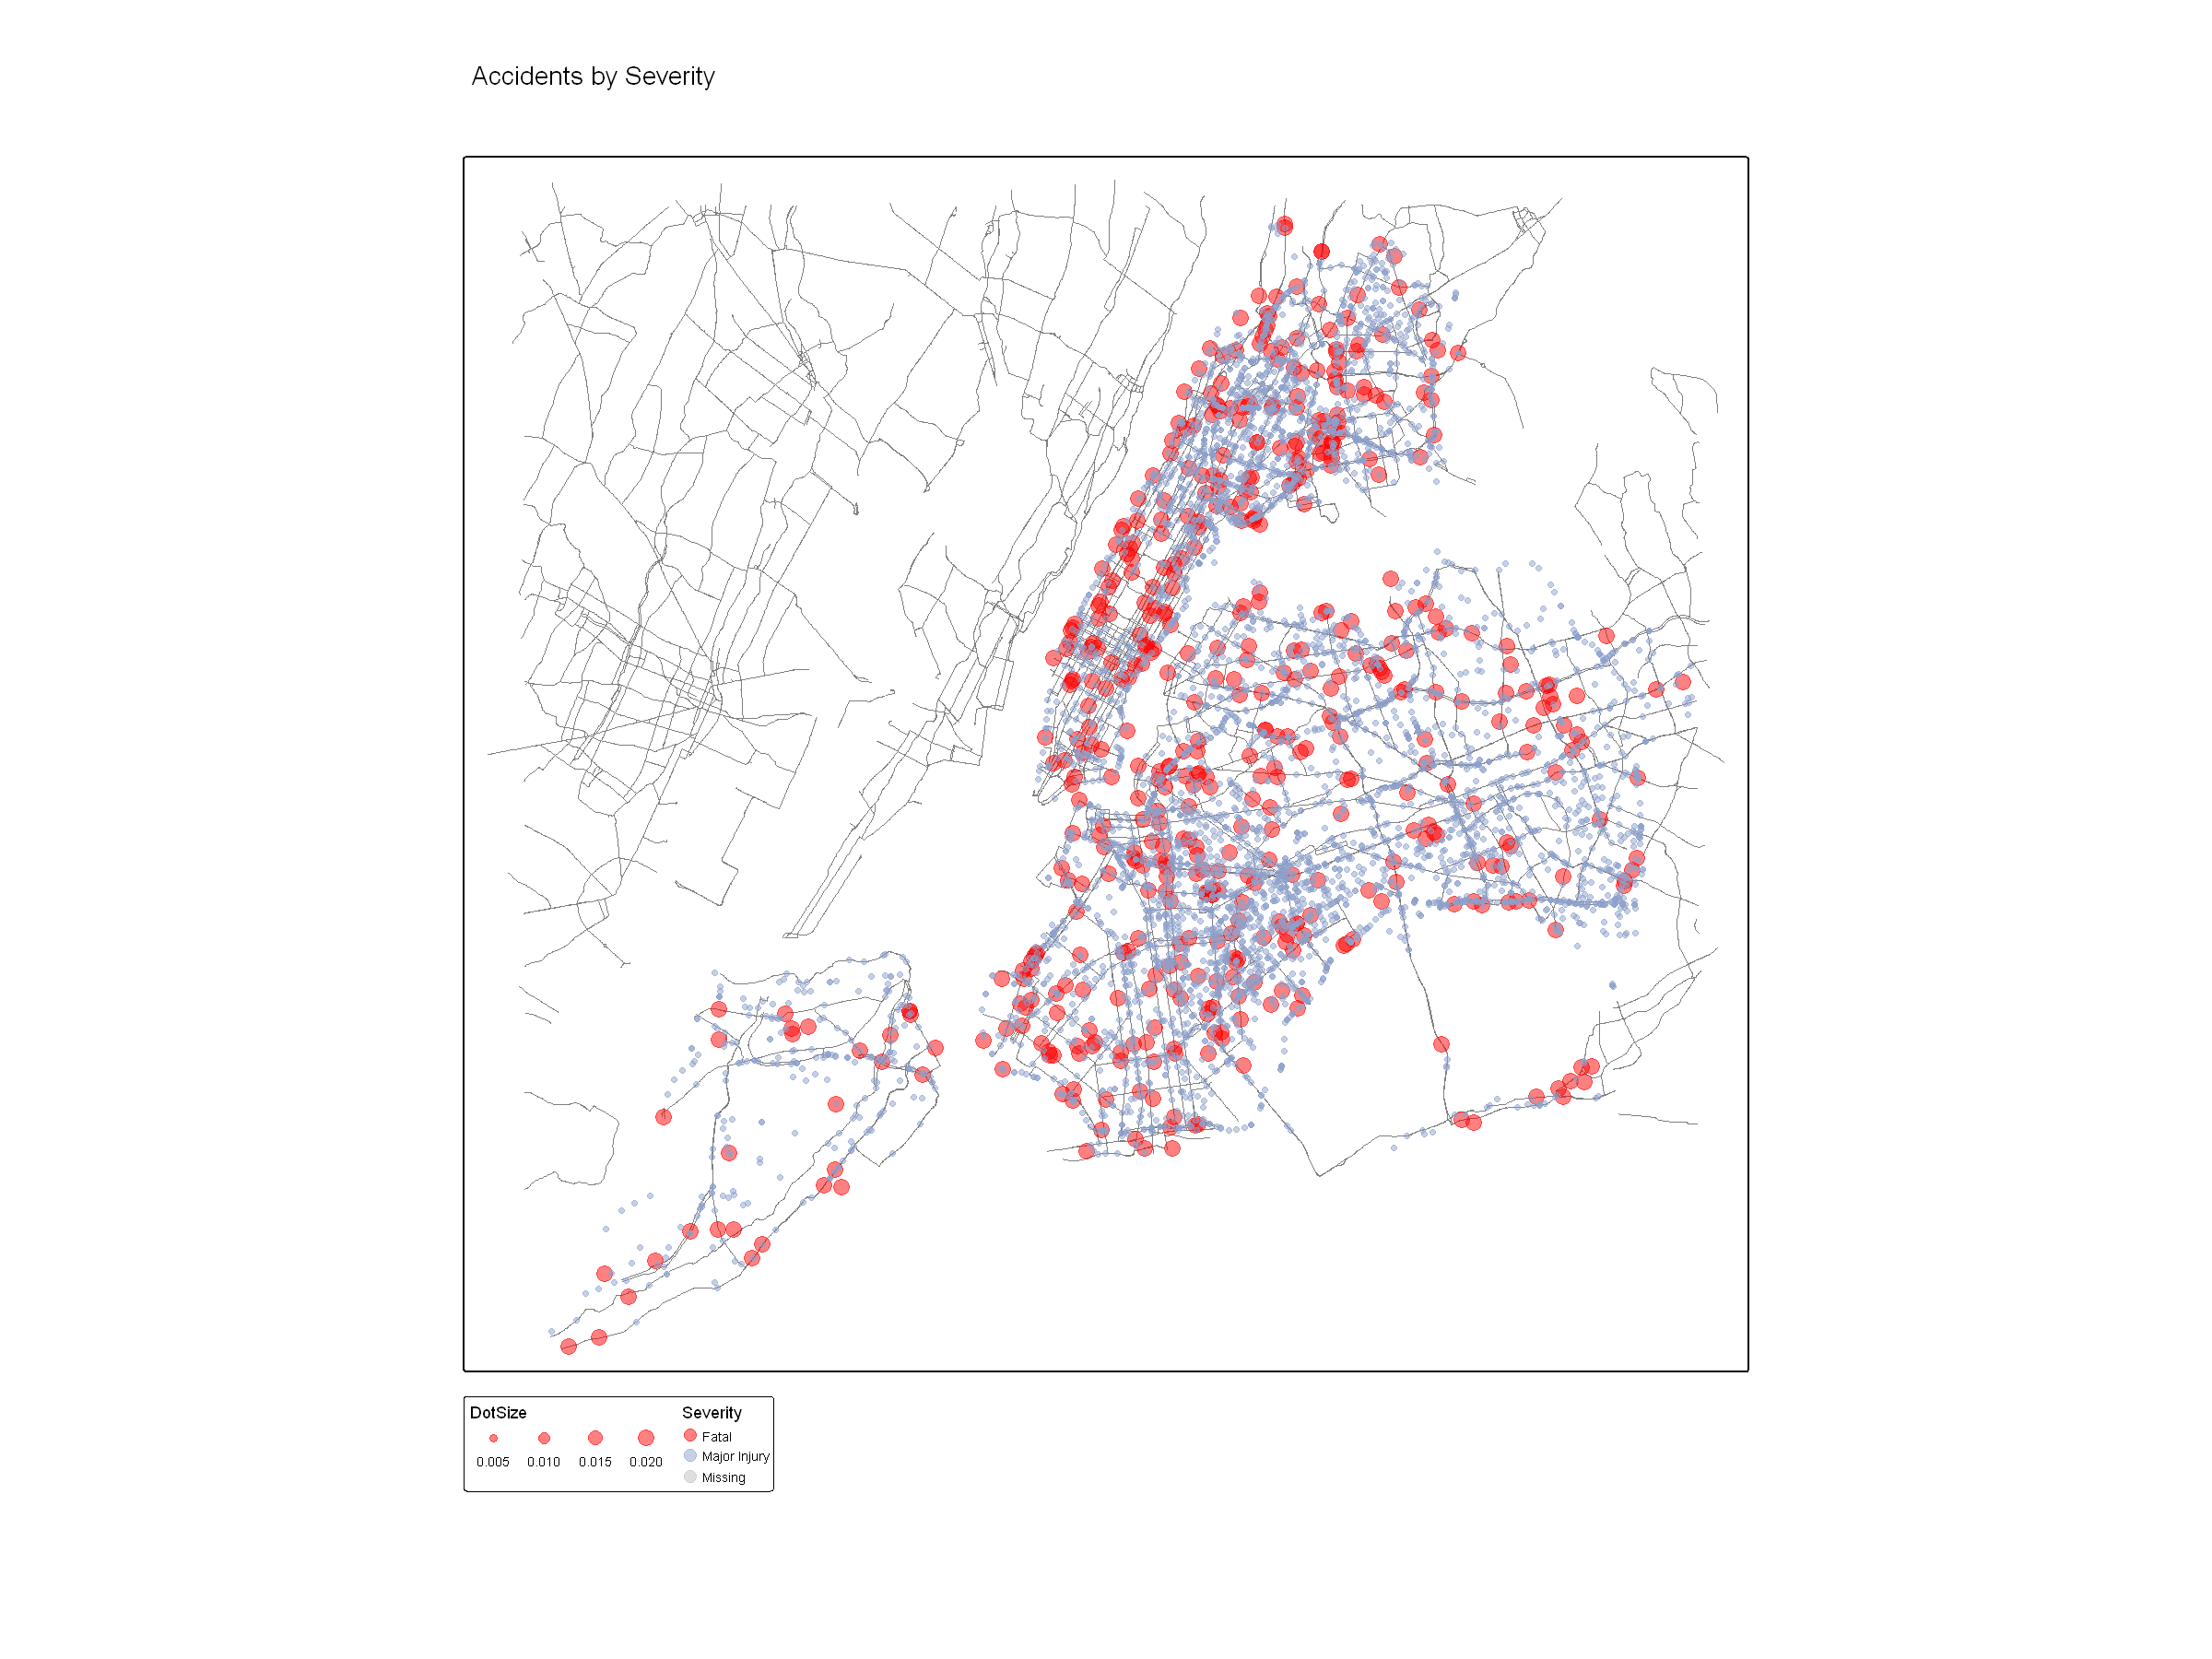

In [ ]:
# Load the dataset
# file.exists("/Users/dilshananurada/NYC_Collisions.csv") #check the file existence 
# accidents = read.csv("NYC_Collisions.csv") # load the dataset
accidents = accidents

names(accidents) <- make.names(names(accidents))

accidents <- accidents %>% drop_na(Latitude, Longitude)
accidents_sf <- st_as_sf(accidents, coords = c("Longitude", "Latitude"), crs = 4326)

# Create severity categories
accidents_sf <- accidents_sf %>%
  mutate(Severity = case_when(
    Persons.Killed > 0 ~ "Fatal",
    Persons.Injured > 2 ~ "Major Injury",
    Persons.Injured > 0 ~ "Minor Injury",
    TRUE ~ "No Injury"
  ))

# Optional: Crop to just Manhattan bounding box
# accidents_sf <- accidents_sf %>% st_crop(nyc_bbox)


# Step 2: Manually construct sf bbox from matrix
bbox_obj <- st_bbox(c(xmin = nyc_bbox[1, 1],
                      ymin = nyc_bbox[2, 1],
                      xmax = nyc_bbox[1, 2],
                      ymax = nyc_bbox[2, 2]),
                    crs = st_crs(4326))  # WGS84

# Step 3: Convert to sfc polygon
nyc_bbox_sf <- st_as_sfc(bbox_obj)

# # Step 4: Filter accidents to only those within the bbox
accidents_sf <- accidents_sf[st_intersects(accidents_sf, nyc_bbox_sf, sparse = FALSE), ]

accidents_sf <- accidents_sf %>%
  mutate(DotSize = case_when(
    Severity == "Fatal" ~ 0.02,
    Severity == "Major Injury" ~ 0.003,
    Severity == "Minor Injury" ~ 0.01,
    Severity == "No Injury" ~ 0.001
  ))
#Filter the Accidents
accidents_sf_filtered <- accidents_sf %>%
  filter(Severity %in% c("Fatal", "Major Injury"))

#Plot the graph
options(repr.plot.width = 20, repr.plot.height = 15)

tm_shape(nyc_streets_lines) +
  tm_lines(col = "grey50", lwd = 0.5) +
  
  tm_shape(accidents_sf_filtered) +
  tm_symbols(col = "Severity",
             size = "DotSize",
             shape = 19,  # solid circle
             palette = c("No Injury"     = "#66c2a5",
                         "Minor Injury"  = "#fdbf6f",
                         "Major Injury"  = "#8da0cb",
                         "Fatal"         = "red"),
             alpha = 0.5,
             title.col = "Accident Severity",
             border.col = NA) +
  
  tm_layout(main.title = "Accidents by Severity",
            main.title.size = 1.4,
            legend.outside = TRUE,
            bg.color = "white")